This page provides a good overview of the math and fundamentals of fourier descriptors.

https://github.com/timfeirg/Fourier-Descriptors



In [1]:
import numpy as np
import matplotlib

%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace


In the first step we just load an image and make sure that it's a greyscale image.

'\nparams = cv2.SimpleBlobDetector_Params()\nparams.blobColor = 255\nparams.filterByColor = True\nparams.minArea = 50\nparams.filterByArea = True\ndetector = cv2.SimpleBlobDetector_create(params)\n\nkeypoints = detector.detect(thresh)\nim_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)\n\nplt.figure(); plt.imshow(im_with_keypoints)'

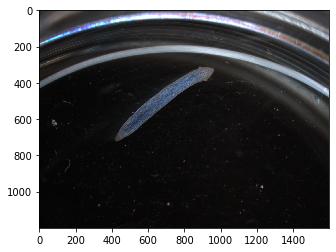

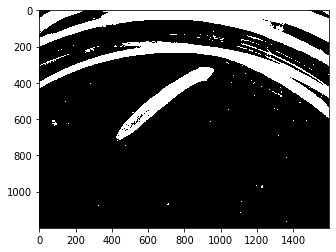

In [2]:
img = cv2.imread('planaria_dataset/day_11/W1-PT-D11.TIF')
plt.figure(); plt.imshow(img)
 
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 60, 255, 0)
plt.figure(); plt.imshow(thresh,cmap="gray")
'''
params = cv2.SimpleBlobDetector_Params()
params.blobColor = 255
params.filterByColor = True
params.minArea = 50
params.filterByArea = True
detector = cv2.SimpleBlobDetector_create(params)

keypoints = detector.detect(thresh)
im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (255,0,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(); plt.imshow(im_with_keypoints)'''

The next step is to find the contours of the image.  There are a couple of different algorithms and options that OpenCV provides.  Note that `countours` and `hierarchy` are both lists.  In the case of the cat (but not in general), the cat's online is the contour found at index 1. (the contour at index 0 is the outer frame of the image)

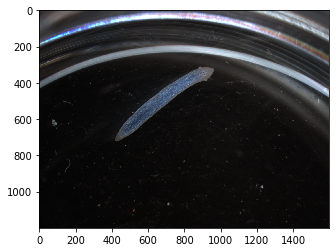

In [3]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
drawn = cv2.drawContours(img, contours, 1, (255,0,0), 2)
plt.figure(); plt.imshow(drawn,cmap="gray")



The contour is actually just a long list of points, ordered in a way that traces the outline of the cat.

The next step is to separate the x and y coordinates of these points

In [4]:
#print(contours[1][0][0])

xs = [pt[0][0] for pt in contours[1]]
ys = [pt[0][1] for pt in contours[1]]

contour_complex = np.empty(len(xs), dtype=complex)
#the x coordinates of the points on the contour
contour_complex.real= xs
# the y coordinates of the points on the contour
contour_complex.imag= ys
#plt.plot(contour_complex.real,contour_complex.imag,'x-')
#the y coordinates of the points on the contour

Next up we run the Fast Fourier Tranform on the points

In [5]:
fourier_result = np.fft.fft(contour_complex)

We can plot what the fourier frequencies look like here

ValueError: x and y must have same first dimension, but have shapes (5,) and (4,)

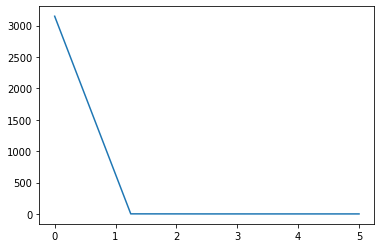

In [6]:


N = len(contour_complex)
T = 1/N
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
xf2 = np.linspace(0.0, -1.0/(2.0*T), (N//2))

backhalf = fourier_result[(N//2)+1:]
backhalf = backhalf[::-1]
plt.plot(xf, 2.0/N * np.abs(fourier_result[0:N//2]))
plt.plot(xf2, 2.0/N * np.abs(backhalf))
plt.show()

One fun thing we can do with the fourier coefficients is "center" the contour by setting the 0th coefficient to 0.

To display what happens when we do so we can run the INVERSE fourier transform on the coefficients to generate the modified contour 

In [ ]:
fourier_result[0] = 0
#print(fourier_result)
new_contour = np.fft.ifft(fourier_result)
plt.plot(new_contour.real,-1*new_contour.imag,'x-')
plt.show()

Next, we can see what happens when we perform a low-pass filter by zeroing out the coefficients above a certain frequency.

Note that the *negative* frequencies begin at index N/2. (read the docs)


In [ ]:
for cutoff in range(0,N//2,10):
    fourier_result2 = fourier_result.copy()
    fourier_result2[cutoff:N//2] = 0+0j
    fourier_result2[(N//2)+cutoff:] = 0+0j
    new_contour2 = np.fft.ifft(fourier_result2)
    plt.plot(new_contour2.real,-1*new_contour2.imag,'x-')
    
plt.show()
    